In [1]:
%cd ".."

/home/ensai/projet-statistique-2022


In [3]:
from gensim import models
from sklearn.manifold import TSNE, MDS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
import scipy.spatial as sp
import scipy.stats
import random
import math

from word_embedding.distance_wmd import *
import mantel_test.correlation as mantel_parallel

# Read WMD Matrix

In [3]:
#Read WMD matrix 
mat_distance_wmd = lecture_fichier_distances_wmd("distances_cbow.7z")
mat_distance_wmd.head()

,0,1,2,3,4,5,6,7,8,9,...,9491,9492,9493,9494,9495,9496,9497,9498,9499,9500
0,0,307,293,386,327,413,329,309,242,632,...,690,370,782,400,277,294,303,327,394,283
1,307,0,81,230,222,370,308,262,131,737,...,735,351,856,419,134,148,160,242,281,115
2,293,81,0,232,229,363,298,239,121,739,...,722,342,853,401,122,145,144,242,260,115
3,386,230,232,0,184,447,350,314,241,758,...,715,451,749,454,188,190,220,176,384,221
4,327,222,229,184,0,397,333,272,218,662,...,680,377,758,390,179,185,221,162,340,194


In [4]:
sample_size = 300
sample_index = random.sample(range(mat_distance_wmd.shape[0]),sample_size)
mat_distance_wmd_sample = np.copy(mat_distance_wmd.values)
mat_distance_wmd_sample = mat_distance_wmd_sample[np.ix_(sample_index,sample_index)]
mat_distance_wmd_sample

array([[  0, 284, 319, ..., 343, 238, 315],
       [284,   0, 342, ..., 311, 234, 249],
       [319, 342,   0, ..., 323, 252, 299],
       ...,
       [343, 311, 323, ...,   0, 212, 207],
       [238, 234, 252, ..., 212,   0, 160],
       [315, 249, 299, ..., 207, 160,   0]], dtype=uint32)

# Doc Embedding from wmd distance approche

## 1) Approche direct

In [5]:
#On considere mat_distance_wmd comme le doc embedding et on calcule la matrice de distance euclidiennes
direct_embedding = np.copy(mat_distance_wmd_sample)

## 2) MDS approche

In [6]:
mds_model = MDS(n_components=300, dissimilarity="precomputed")
mds_embedding = mds_model.fit_transform(mat_distance_wmd_sample)

## 3) Geometrical/Gramm approach

In [7]:
def x_coord_of_point(D, j):
    return ( D[0,j]**2 + D[0,1]**2 - D[1,j]**2 ) / ( 2*D[0,1] )

def coords_of_point(D, j):
    x = x_coord_of_point(D, j)
    return np.array([x, math.sqrt( D[0,j]**2 - x**2 )])
    
def calculate_positions(D):
    (m, n) = D.shape
    P = np.zeros( (n, 2) )
    tr = ( min(min(D[2,0:2]), min(D[2,3:n])) / 2)**2
    P[1,0] = D[0,1]
    P[2,:] = coords_of_point(D, 2)
    for j in range(3,n):
        P[j,:] = coords_of_point(D, j) 
        if abs( np.dot(P[j,:] - P[2,:], P[j,:] - P[2,:]) - D[2,j]**2 ) > tr:
            P[j,1] = - P[j,1]
    return P 

In [8]:
gram_embedding = calculate_positions(mat_distance_wmd_sample)

# Comparaison

In [9]:
nb_doc = nb_prop = mat_distance_wmd_sample.shape[0]
flat_index = np.triu_indices(nb_doc)

In [10]:
# Matrices de distance
direct_distance = euclidean_distances(direct_embedding)
mds_distance = euclidean_distances(mds_embedding)
gram_distance = euclidean_distances(gram_embedding)

# Flat array
wmd_flat = mat_distance_wmd_sample[flat_index]
direct_flat = direct_distance[flat_index]
mds_flat = mds_distance[flat_index]
gram_flat = gram_distance[flat_index]

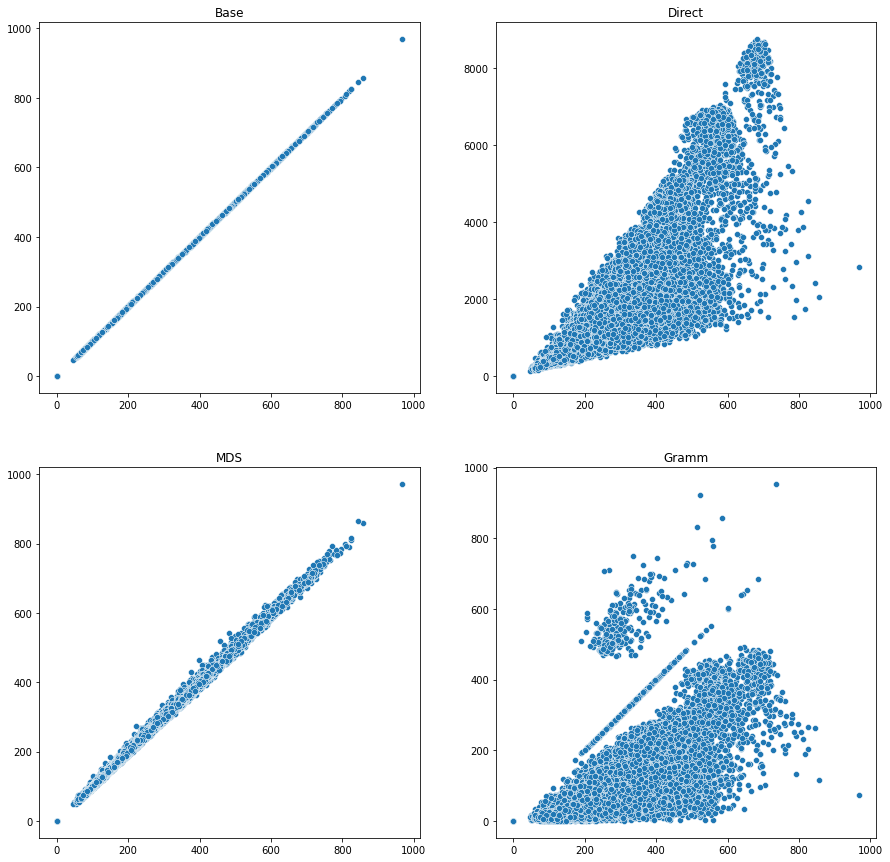

In [11]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))

sns.scatterplot(x=wmd_flat,y=wmd_flat,ax=axs[0,0])
axs[0,0].set_title("Base")

sns.scatterplot(x=wmd_flat,y=direct_flat,ax=axs[0,1])
axs[0,1].set_title("Direct")

sns.scatterplot(x=wmd_flat,y=mds_flat,ax=axs[1,0])
axs[1,0].set_title("MDS")

sns.scatterplot(x=wmd_flat,y=gram_flat,ax=axs[1,1])
axs[1,1].set_title("Gramm")
plt.show()

loop time 2.351245403289795
denominateur time 0.006146669387817383
Coefficient: 0.9989535442874684 -- pvalue empirique : 0.0001


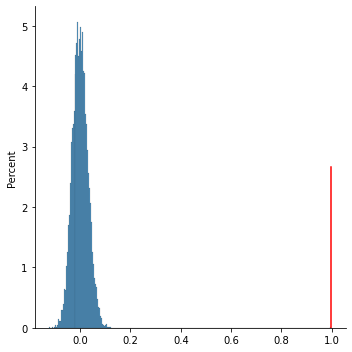

In [12]:
r,p,z,coeffs = mantel_parallel.test(wmd_flat,mds_flat)
print(f"Coefficient: {r} -- pvalue empirique : {p}")
sns.displot(coeffs, stat='percent')
plt.axvline(r, 0,0.5,color='red')
plt.show()

loop time 2.3146471977233887
denominateur time 0.0061533451080322266
Coefficient: 0.7084662792820879 -- pvalue empirique : 0.0001


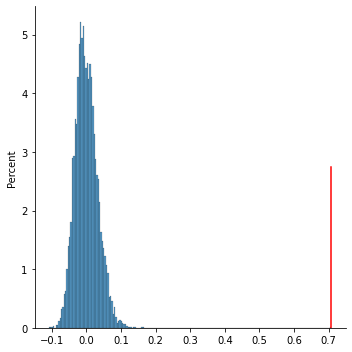

In [13]:
r,p,z,coeffs = mantel_parallel.test(wmd_flat,gram_flat)
print(f"Coefficient: {r} -- pvalue empirique : {p}")
sns.displot(coeffs, stat='percent')
plt.axvline(r, 0,0.5,color='red')
plt.show()